For me, this VSB power line competition was a good chance to learn how to use LSTM or RNN in general (I expect GRU should not be much different to apply with Keras..). I need a place to write things down so I remember another day and not just today. I wrote myself a [blog post](https://swenotes.wordpress.com/2019/02/22/learning-to-lstm/) to remind myself. This kernel is an attempt to put some working code somewhere.

If I got any part wrong about here, or missing something, do let me know :).

I started with the [kernel](https://www.kaggle.com/braquino/5-fold-lstm-attention-fully-commented-0-694) by Bruno Marek. Then played with the data and classifiers myself, built a separate [preprocessing kernel](https://www.kaggle.com/donkeys/preprocessing-with-python-multiprocessing) as well. This kernel uses data produced by that preprocessing kernel.

There are other public kernels in the competition with better scores but I wanted to keep this simple to help myself more clearly understand the core concepts.


In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from keras.layers import *
from keras.models import Model
from sklearn.model_selection import train_test_split 
from keras import backend as K 
from keras import optimizers
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from keras.callbacks import *
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

Matthews correlation coefficient is simply the measure given in this Kaggle competition as a way to measure the score. It [seems](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) that a value of 1 would mean perfect prediction, and 0 equal to random values. So maybe 0.6-0.7 that many kernels get is not all that bad? 

In [3]:
def matthews_correlation_coeff(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)

    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [4]:
# load the training set metadata, defines which signals are in which order in the data
train_meta = pd.read_csv('../input/vsb-power-line-fault-detection/metadata_train.csv')
# set index, it makes the data access much faster
train_meta = train_meta.set_index(['id_measurement', 'phase'])
train_meta.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [5]:
# load the test set metadata, defines which signals are in which order in the data
test_meta = pd.read_csv('../input/vsb-power-line-fault-detection/metadata_train.csv')
# set index, it makes the data access much faster
test_meta = test_meta.set_index(['id_measurement', 'phase'])
test_meta.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [6]:
!ls ../input/preprocessing-with-python-multiprocessing

__notebook__.ipynb  my_test_combined_scaled.csv.gz
__output__.json     my_test_scaled.csv.gz
__results__.html    my_train.csv.gz
__results___files   my_train_combined_scaled.csv.gz
custom.css	    my_train_scaled.csv.gz
my_test.csv.gz


The data files produced by the preprocessing kernel is shown above. I had to compress them using gzip to fit them into the kernel 5GB output size limit. Hence the decompression and the filename suffix here.

In [7]:
df_test_pre = pd.read_csv("../input/preprocessing-with-python-multiprocessing/my_test_combined_scaled.csv.gz", compression="gzip")

In [8]:
df_test_pre.shape

(1084640, 67)

The test dataframe loaded above has 22 features calculated for each of the 3 signals per measurement id. So 66 columns. It becomes 67 when loaded, because dumping the values to disk with pandas.to_csv seems to have generated one extra column (maybe the index?).  Number of actual rows should match the number of measurement id's in the corresponding dataset:

In [9]:
1084640/160

6779.0

The training data-set should look about the same but with only the 2904 measurements, so fewer rows:

In [10]:
df_train_pre = pd.read_csv("../input/preprocessing-with-python-multiprocessing/my_train_combined_scaled.csv.gz", compression="gzip")
df_train_pre.shape

(464640, 67)

To drop the excess column:

In [11]:
df_train_pre.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '63', '64', '65'],
      dtype='object')

In [12]:
df_train_pre.drop("Unnamed: 0", axis=1, inplace=True)
df_test_pre.drop("Unnamed: 0", axis=1, inplace=True)

The preprocessed data has 160 timesteps. Number of rows should match the number of measurements times the number of timesteps:

In [13]:
#number of "observations" in test dataset
df_test_pre.shape[0]/160

6779.0

In [14]:
df_train_pre.shape

(464640, 66)

In [15]:
#number of "observations" in training dataset
464640/160

2904.0

In [16]:
train_meta.index.get_level_values('id_measurement').unique()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903],
           dtype='int64', name='id_measurement', length=2904)

LSTM is about timesteps, and in this case the 800k measurements per signal were summarized to 160 timesteps per signal in the pre-processing. So things like average values of 5000 measurementes (800k/5000=160). These are now in rows 0-159 for the first measurements id, where the columns 0-21 are for the first signal, columns 22-43 for second signal, and 44-65 for the third signal.

This continues for the following measurements with the 3 signals per measurement id in the columns. So the signals for the second measurement id are in rows 160-319.

A look at first signal for the first measurement id:

In [17]:
pd.set_option('display.max_rows', 5)
df_train_pre.iloc[0:160,:22]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.494648,-0.952345,0.357633,0.578792,-0.968254,-0.890359,-0.953549,-0.890387,0.868421,0.738318,0.550,0.506494,0.382716,-0.009618,-0.376623,0.978171,0.957951,0.830951,-0.036067,-0.924594,-0.943128,-0.972498
1,0.489032,-0.931789,0.357123,0.568724,-0.960317,-0.880009,-0.945913,-0.880009,0.855263,0.719626,0.550,0.506494,0.382716,-0.009618,-0.376623,0.968572,0.931391,0.868738,0.076707,-0.888232,-0.935788,-0.969848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.513685,-0.933146,0.380146,0.592253,-0.896825,-0.852738,-0.931397,-0.852738,0.776316,0.738318,0.575,0.506494,0.407407,0.009428,-0.350649,0.883337,0.932998,0.876992,-0.418356,-0.880289,-0.934185,-0.957056
159,0.503390,-0.943940,0.367875,0.585069,-0.944444,-0.880590,-0.945568,-0.880590,0.842105,0.738318,0.550,0.506494,0.407407,-0.009618,-0.363636,0.949511,0.946492,0.772128,-0.211620,-0.813630,-0.954552,-0.964410


Second signal:

In [18]:
df_train_pre.iloc[0:160,22:44]

,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,0.050128,-0.955448,-0.063952,0.160955,-0.960317,-0.899325,-0.959588,-0.899351,0.631579,0.420561,0.125,0.064935,-0.037037,-0.352443,-0.597403,0.968076,0.963942,0.861703,0.055711,-0.895001,-0.970975,-0.970341
1,0.091872,-0.936412,-0.019979,0.195834,-0.960317,-0.888039,-0.951721,-0.888039,0.657895,0.439252,0.175,0.090909,0.012346,-0.295305,-0.571429,0.972821,0.943148,0.929093,-0.262862,-0.830152,-0.924066,-0.965615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,-0.019824,-0.932546,-0.124825,0.089763,-0.849206,-0.866652,-0.938501,-0.866652,0.500000,0.364486,0.050,-0.012987,-0.086420,-0.390534,-0.545455,0.878620,0.953867,0.809985,-0.098638,-0.777201,-0.947199,-0.888475
159,0.020600,-0.931131,-0.086222,0.127496,-0.952381,-0.891018,-0.951423,-0.891018,0.605263,0.383178,0.100,0.012987,-0.061728,-0.352443,-0.610390,0.957546,0.934803,0.886256,-0.390708,-0.871374,-0.932386,-0.968619


Third signal:

In [19]:
df_train_pre.iloc[0:160,44:66]

,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,-0.473546,-0.938704,-0.555837,-0.336029,-0.944444,-0.901068,-0.959178,-0.901093,0.355263,0.028037,-0.375,-0.480519,-0.530864,-0.714313,-0.844156,0.958701,0.937998,0.902659,-0.341752,-0.855589,-0.929200,-0.955255
1,-0.498778,-0.934701,-0.578790,-0.360719,-0.960317,-0.882963,-0.948802,-0.882963,0.355263,0.009346,-0.400,-0.506494,-0.555556,-0.733359,-0.870130,0.970653,0.937150,0.898306,-0.354745,-0.859778,-0.930046,-0.967774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,-0.418144,-0.941282,-0.503986,-0.283263,-0.912698,-0.877181,-0.943457,-0.877181,0.328947,0.065421,-0.325,-0.428571,-0.481481,-0.676221,-0.818182,0.907937,0.933222,0.878141,-0.414926,-0.879183,-0.933962,-0.956975
159,-0.447092,-0.939463,-0.530969,-0.310944,-0.960317,-0.892205,-0.950902,-0.892205,0.381579,0.046729,-0.350,-0.454545,-0.506173,-0.695267,-0.844156,0.970688,0.937245,0.898793,-0.353290,-0.859309,-0.929951,-0.967740


And the 3 signals for the second measurement id:

In [20]:
df_train_pre.iloc[160:320]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
160,-0.369433,-0.953609,-0.460751,-0.234531,-0.865079,-0.959812,-0.973771,-0.959826,0.355263,0.102804,-0.275,-0.376623,-0.432099,-0.657176,-0.714286,0.909381,0.937218,0.898654,-0.353705,-0.859443,-0.963799,-0.882256,-0.103595,-0.959423,-0.210422,0.017134,-0.944444,-0.964459,-0.984430,-0.964472,0.552632,0.308411,-0.025,-0.090909,-0.185185,-0.466717,-0.649351,0.967341,0.961906,0.851255,0.024530,-0.905056,-0.973005,-0.946647,0.547861,-0.955799,0.407206,0.629701,-0.888889,-0.961075,-0.971403,-0.961089,0.828947,0.775701,0.6,0.558442,0.432099,0.028473,-0.285714,0.916185,0.956045,0.821164,-0.065274,-0.934011,-0.945028,-0.912118
161,-0.346308,-0.950447,-0.438117,-0.213491,-0.801587,-0.956140,-0.958566,-0.956140,0.328947,0.121495,-0.250,-0.350649,-0.407407,-0.638130,-0.636364,0.873907,0.940827,0.917182,-0.298410,-0.841614,-0.960200,-0.819890,-0.125541,-0.958939,-0.231087,-0.003643,-0.912698,-0.963185,-0.979853,-0.963185,0.513158,0.289720,-0.050,-0.116883,-0.209877,-0.466717,-0.636364,0.940959,0.956750,0.824786,-0.054464,-0.930526,-0.944325,-0.924077,0.546355,-0.951482,0.406790,0.627279,-0.809524,-0.955357,-0.949939,-0.955357,0.763158,0.775701,0.6,0.558442,0.432099,0.028473,-0.220779,0.855601,0.958019,0.831299,-0.035028,-0.924259,-0.943060,-0.850341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,-0.408335,-0.958612,-0.498752,-0.269997,-0.928571,-0.964296,-0.979347,-0.964296,0.394737,0.084112,-0.325,-0.402597,-0.481481,-0.676221,-0.779221,0.964587,0.954287,0.812144,-0.092194,-0.942691,-0.946780,-0.924964,-0.056101,-0.958038,-0.165133,0.061532,-0.936508,-0.967427,-0.984778,-0.967427,0.539474,0.327103,0.025,-0.064935,-0.135802,-0.428626,-0.649351,0.932583,0.933575,0.879952,-0.409521,-0.877440,-0.967431,-0.969061,0.538198,-0.956311,0.397938,0.620721,-0.912698,-0.962326,-0.974544,-0.962326,0.842105,0.757009,0.6,0.532468,0.432099,0.009428,-0.311688,0.933022,0.934789,0.886186,-0.390916,-0.871441,-0.966220,-0.931984
319,-0.387611,-0.958211,-0.479037,-0.250577,-0.912698,-0.965684,-0.979653,-0.965684,0.368421,0.102804,-0.300,-0.376623,-0.456790,-0.676221,-0.779221,0.930251,0.961045,0.846832,0.011329,-0.909312,-0.973864,-0.934744,-0.084046,-0.960776,-0.192230,0.035856,-0.952381,-0.972022,-0.986385,-0.972022,0.552632,0.327103,0.000,-0.090909,-0.160494,-0.447672,-0.662338,0.958080,0.970203,0.893848,-0.368049,-0.864068,-0.964732,-0.968087,0.545744,-0.959408,0.404358,0.628547,-0.944444,-0.966240,-0.980883,-0.966240,0.868421,0.775701,0.6,0.558442,0.432099,0.028473,-0.337662,0.953966,0.958819,0.835408,-0.022763,-0.920304,-0.942262,-0.959972


In [21]:
pd.reset_option('display.max_rows')

In [22]:
from sklearn.metrics import matthews_corrcoef

# The output of this kernel must be binary (0 or 1), but the output of the NN Model is float (0 to 1).
# So, find the best threshold to convert float to binary is crucial to the result
# this piece of code is a function that evaluates all the possible thresholds from 0 to 1 by 0.01
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    scores = []
    for threshold in [i * 0.01 for i in range(100)]:
        yp_np = np.array(y_proba)
        yp_bool = yp_np >= threshold
        score = matthews_corrcoef(y_true, yp_bool)
        #score = K.eval(matthews_correlation(y_true.astype(np.float64), (y_proba > threshold).astype(np.float64)))
        scores.append(score)
        if score > best_score:
            print("found better score:"+str(score)+", th="+str(threshold))
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    scores_df = pd.DataFrame({"score": scores})
    print("scores plot:")
    scores_df.plot()
    plt.show()
    return search_result

Create the actual LSTM model. For more explanations, see my [blog post](https://swenotes.wordpress.com/2019/02/22/learning-to-lstm/).

In [23]:
def create_model(input_data):
    input_shape = input_data.shape
    inp = Input(shape=(input_shape[1], input_shape[2],), name="input_signal")
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True, name="lstm1"), name="bi1")(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=False, name="lstm2"), name="bi2")(x)
    #other kernels have used also a custom Attention layer but I leave it out for simplicity here
#    x = Attention(input_shape[1])(x)
    x = Dense(128, activation="relu", name="dense1")(x)
    x = Dense(64, activation="relu", name="dense2")(x)
    x = Dense(1, activation='sigmoid', name="output")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation_coeff])
    return model

Since the dataset has been combined to have all 3 phase signals per measurement id on a single row (22\*3=66 features/columns), as combined features, I need to combine the prediction targets for all 3 signals also into one. 

In [24]:
#if any of the 3 signals for a measurement id is labeled as faulty, this labels the whole set of 3 as faulty
y = (train_meta.groupby("id_measurement").sum()/3 > 0)["target"]

In [25]:
#to see the number of targets matches the number of rows in training dataset
y.shape

(2904,)

LSTM requires 3-dimensional input, so this reshapes the dataframe values from 2D dataframe to a 3D numpy matrix in the required format. 2904 observations, 160 timesteps, each with 66 features. 

Features for each timestep are on a single row in the dataframe (66 on a row) as is. The dataframe here being "df_train_pre". The dataframe has 160 rows per measurement id as shown above (df_train_pre.iloc[0:160] for measurement id 1 and df_train_pre.iloc[160:320] for measurement id 2, and so on). Each of these measurement id sets should be its own "observation" in the numpy matrix used as input for the LSTM. 

The following reshape creates the required input format, setting the overall input shape as (2904, 160, 66). This is 2904 observations, 160 timesteps for each of those 2904 observations, and 66 features for each of those 160 timesteps. This is the 3D format format LSTM expects as input. A timestep has been formed by splitting the sequence of signal values over time to 160 separate values on after the other, and collecting the 66 features for that timeslot.

In [26]:
#if using all signal values separately, the number of rows would be 8712, or 2904*3.
#X = df_train_pre.values.reshape(8712, 160, 22)
#but with the current data format I show above, it is 2904 rows, or "observations"
X = df_train_pre.values.reshape(2904, 160, 66)
X.shape

(2904, 160, 66)

Now to do the same for the test-dataset, but remembering it has more rows, so the first dimension is higher. Maybe because the people at Kaggle want to make life difficult for the competitors and so the test set is much bigger :).

In [27]:
X_test = df_test_pre.values.reshape(6779, 160, 66)

Finally, train and run a simple LSTM classifier for all this:

Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 4s 2ms/step - loss: 0.3178 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2456 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00001: val_matthews_correlation_coeff improved from -inf to 0.00000, saving model to weights.h5
Epoch 2/50
2323/2323 [==============================] - 1s 539us/step - loss: 0.2458 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2440 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00002: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 540us/step - loss: 0.2432 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2411 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00003: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 4/50
2323/2323 [==============================] - 1s 541us/step - loss: 0.2412 - matthews_correlation_coeff: 0.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


found better score:0.1415128685786186, th=0.01
found better score:0.2465212123683504, th=0.02
found better score:0.30229914450062456, th=0.03
found better score:0.31776458765870236, th=0.04
found better score:0.33340217684654555, th=0.05
found better score:0.34861122032586195, th=0.06
found better score:0.36661456923387986, th=0.07
found better score:0.375299816920896, th=0.08
found better score:0.3856817757059246, th=0.1
found better score:0.38985079269855577, th=0.12
found better score:0.39745803194189216, th=0.14
found better score:0.40209582745322736, th=0.15
found better score:0.41413586917801515, th=0.16
found better score:0.42168761021819906, th=0.17
found better score:0.4268687517719549, th=0.18
found better score:0.45179774191906286, th=0.19
found better score:0.45477253510860993, th=0.2
found better score:0.4849901407190725, th=0.21
found better score:0.49602133400129295, th=0.22
found better score:0.5239987409133151, th=0.23
found better score:0.5707072736576622, th=0.24
fou

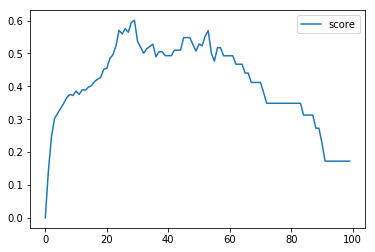

predicting test set
6779/6779 [==============================] - 1s 184us/step
Beginning fold 2
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 937us/step - loss: 0.3098 - matthews_correlation_coeff: 0.0086 - val_loss: 0.2451 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00001: val_matthews_correlation_coeff improved from -inf to 0.00000, saving model to weights.h5
Epoch 2/50
2323/2323 [==============================] - 1s 501us/step - loss: 0.2438 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2440 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00002: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 500us/step - loss: 0.2398 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2356 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00003: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 4/50
2323/2323 [==================

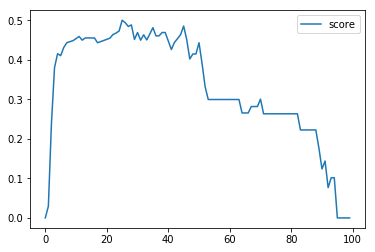

predicting test set
6779/6779 [==============================] - 1s 143us/step
Beginning fold 3
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 979us/step - loss: 0.2863 - matthews_correlation_coeff: -0.0058 - val_loss: 0.2474 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00001: val_matthews_correlation_coeff improved from -inf to 0.00000, saving model to weights.h5
Epoch 2/50
2323/2323 [==============================] - 1s 467us/step - loss: 0.2432 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2462 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00002: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 472us/step - loss: 0.2416 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2447 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00003: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 4/50
2323/2323 [=================

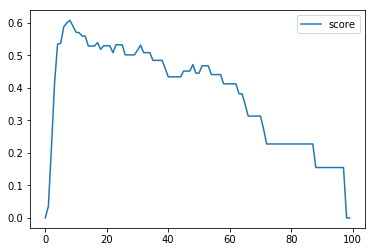

predicting test set
6779/6779 [==============================] - 1s 183us/step
Beginning fold 4
Train on 2323 samples, validate on 581 samples
Epoch 1/50
2323/2323 [==============================] - 2s 933us/step - loss: 0.3011 - matthews_correlation_coeff: 0.0014 - val_loss: 0.2569 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00001: val_matthews_correlation_coeff improved from -inf to 0.00000, saving model to weights.h5
Epoch 2/50
2323/2323 [==============================] - 1s 502us/step - loss: 0.2454 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2432 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00002: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 3/50
2323/2323 [==============================] - 1s 495us/step - loss: 0.2403 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2369 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00003: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 4/50
2323/2323 [==================

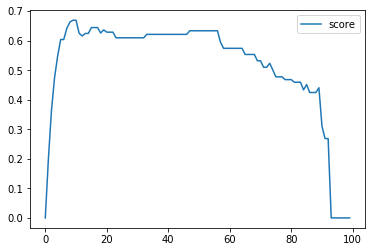

predicting test set
6779/6779 [==============================] - 1s 142us/step
Beginning fold 5
Train on 2324 samples, validate on 580 samples
Epoch 1/50
2324/2324 [==============================] - 2s 931us/step - loss: 0.2963 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2801 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00001: val_matthews_correlation_coeff improved from -inf to 0.00000, saving model to weights.h5
Epoch 2/50
2324/2324 [==============================] - 1s 498us/step - loss: 0.2522 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2371 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00002: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 3/50
2324/2324 [==============================] - 1s 500us/step - loss: 0.2377 - matthews_correlation_coeff: 0.0000e+00 - val_loss: 0.2450 - val_matthews_correlation_coeff: 0.0000e+00

Epoch 00003: val_matthews_correlation_coeff did not improve from 0.00000
Epoch 4/50
2324/2324 [==============

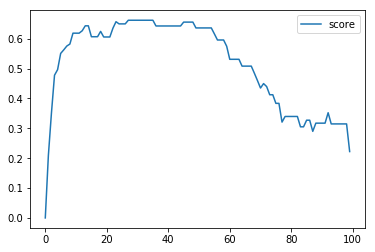

predicting test set
6779/6779 [==============================] - 1s 182us/step


In [28]:
eval_preds = np.zeros(X.shape[0])
label_predictions = []

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=123).split(X, y))
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]

    model = create_model(X)
    #checkpoint to save model with best validation score. keras seems to add val_xxxxx as name for metric to use here
    ckpt = ModelCheckpoint('weights.h5', save_best_only=True, save_weights_only=True, monitor='val_matthews_correlation_coeff', verbose=1, mode='max')
    earlystopper = EarlyStopping(patience=25, verbose=1) 
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt, earlystopper])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights.h5')

    print("finding threshold")
    predictions = model.predict(val_X, batch_size=512)
    best_threshold = threshold_search(val_y, predictions)['threshold']
    
    print("predicting test set")
    pred = model.predict(X_test, batch_size=300, verbose=1)
    pred_bool = pred > best_threshold
    labels = pred_bool.astype("int32")
    label_predictions.append(labels)
    


Convert the above predictions into suitable submission format for the competition:

In [29]:
label_predictions = [pred.flatten() for pred in label_predictions]

import scipy

# Ensemble with voting
labels = np.array(label_predictions)
#convert list of predictions into set of columns
labels = np.transpose(labels, (1, 0))
#take most common value (0 or 1) or each row
labels = scipy.stats.mode(labels, axis=-1)[0]
labels = np.squeeze(labels)

submission = pd.read_csv('../input/vsb-power-line-fault-detection/sample_submission.csv')
labels3 = np.repeat(labels, 3)
submission['target'] = labels3
submission.to_csv('_voted_submission.csv', index=False)
submission.head()

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


Just a quick look at how many positive (faulty power line) predictions did we get:

In [30]:
sum(labels3)

1242